
<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="780" height="140" align="right"/>

<p align="center">Curso: Metodos Estadisticos</p>

<p align="center"> Código Curso: 203008067 </p>

<p align="center"> Grupo: 7 </p>

 <p align="center">  Tarea 3: Aprendizaje Estadistico No Supervisado </p>

 <p align="center">  Presentado por: Juan José García Sánchez </p>

<p align="center"> Código: 203008077</p>

 <p align="center"> Tutor(a): Mireya García García </p>

 <p align="center"> 26/11/2024 </p>

 <p align="center"> UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA - UNAD </p>



# Objetivo General

### Aplicar modelos de agrupamiento sobre el dataset de precios dinamicos, usando conocimientos de estadistica y  aprendizaje automatico, para realizar un exploración de los datos  y encontrar posibles relaciones o patrones desconocidos entre caracteristicas. 

# Objetivos Especificos

### Examinar la relevancia de las caracteristicas, usando un analisis de componentes principales, para determinar cuales se va usaran en la exploración y clustering del dataset.

### Construir dos modelos de aprendizaje no supervisado, usando los algoritmos de agrupamiento KNN y aglomerativo jerarquico, para realizar un agrupamiento de los datos, y descubrir patrones o similarides entre los puntos de datos. 

### Evaluar los clusteres formados, usando los estadisticos de resumen, metricas y visualizaciones, para hallar su similaridad y relaciones encontradas. 

# Importar librerias

In [31]:
from itertools import chain, combinations
from enum import Enum

import pandas as pd
formato = "{:.3f}"
pd.options.display.float_format = formato.format

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, binarize, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Funciones para Visualización:

Se defininen varias funciones para graficar los resultados del analisis de componentes principales, y de los agrupamientos.

In [19]:
def heatmap(matriz, titulo, formato=".2f", tamaño = (4, 4), mapa="Reds"):
    """
    Presentar un vision grafica de una matrix, com un mapa de calor.
    """
    plt.figure(figsize=tamaño)
    
    sns.heatmap(matriz, annot=True, cmap=mapa, fmt=formato)
    
    plt.title(titulo)

              
def cluster_plot(data_x, data_y, labels, titulos, data_centroides=None):
    """
    graficar los puntos de datos y los centroides para los resultados 
    de clasificaciones de agrupamiento.
    """

    fig = plt.figure(figsize=(5,5))

    ax  =  fig.add_subplot(1, 1, 1)

    # Graficar los datos y los centros de clústeres
    ax.scatter(data_x, data_y, c=labels, cmap='viridis')

    if data_centroides is not None:
        ax.scatter(*data_centroides, s=200, marker='^', c='red')

    ax.set_title(titulos[0])
    ax.set_xlabel(titulos[1])
    ax.set_ylabel(titulos[2])        

    plt.show()


def punto_codo(x, y):
    """
    hallar el punto de codo de un modelo de clasificacion por agrupación,
    o en el contexto de un PCA
    """
    # Crear la línea desde el primer hasta el último punto

    #colocar x en una matrix con y, donde las filas seran el conjunto de puntos: [[x1, y1], [x2, y2], [x3, y3]...]
    puntos = np.vstack((x, y)).T

    extremo_menor = puntos[0,:]

    # vectores diferencia entre el punto menor y cada punto
    dif = extremo_menor - puntos

    # vector diferencia entre el punto extremo mayor y el menor
    dif_extremos = dif[-1,:]

    # Calcular la distancia de cada punto a la línea, usando el producto punto
    norma_extremos = np.linalg.norm(dif_extremos)

    distancias = np.abs(np.cross(dif_extremos, dif)) / norma_extremos

    # El punto con la máxima distancia es el codo
    indice_codo = np.argmax(distancias)
    
    return x[indice_codo]


def grafico_codo(numero_clusteres, suma_distancias, titulos, punto_codo=None):
    fig = plt.figure(figsize=(8, 5))

    ax = fig.add_subplot(1, 1, 1)
    
    ax.plot(numero_clusteres, suma_distancias, marker='o', linestyle='-', color='b')
    ax.set_title(titulos[0])
    ax.set_xlabel(titulos[1])
    ax.set_ylabel(titulos[2])

    if punto_codo is not None:
        ax.axvline(x=punto_codo, linestyle='--', color='r', label=f"Codo en x = {punto_codo:d}")
        ax.legend()
        
    ax.grid(True)
    plt.show()

def conjunto_cluster_plot(data_x, caracteristicas, modelo_kmeans):

    labels = modelo_kmeans.labels_
    cant_caracteristicas = len(caracteristicas)

    try:
        centroides = modelo_kmeans.cluster_centers_
        
        for variable_1 in range(cant_caracteristicas):
            for variable_2 in range(variable_1 + 1, cant_caracteristicas):
    
                cluster_plot(data_x[:, variable_1], data_x[:, variable_2],
                             labels, ('Resultados de K-Means', caracteristicas[variable_1], caracteristicas[variable_2]),
                             data_centroides=(centroides[:, variable_1], centroides[:, variable_2])
                            )

    except AttributeError:
        
        for variable_1 in range(cant_caracteristicas):
            for variable_2 in range(variable_1 + 1, cant_caracteristicas):
    
                cluster_plot(data_x[:, variable_1], data_x[:, variable_2],
                             labels, ('Agglomerative Clustering', caracteristicas[variable_1], caracteristicas[variable_2])
                            )


# Variables:

Las siguientes clases definen enumeraciones. Su función es simplemente contener constantes en un solo conjunto, para evitar los errores en el codigo.

In [6]:
# Variables categoricas del dataset
class Categ(Enum):
    locacion = "Location_Category"
    lealtad = "Customer_Loyalty_Status"
    tiempo_viaje = "Time_of_Booking"
    vehiculo = "Vehicle_Type"

# Variables numericas del dataset
class Num(Enum):
    viajes_pasados = "Number_of_Past_Rides"
    puntaje_promedio = "Average_Ratings"
    pasajeros = "Number_of_Riders" 	
    conductores = "Number_of_Drivers"
    duracion_esperada = "Expected_Ride_Duration"
    costo_historico = "Historical_Cost_of_Ride"

# Limpieza de datos

Se realiza el cargue de los datos, y se eliminan los datos nulos: 

In [7]:
# Carga los datos en un dataframe de Pandas

#limpiado de datos, el archivo csv debe estar en el mismo directorio
df_crudo = pd.read_csv('Anexo 1- Base de Datos dynamic_pricing.csv')

df_crudo.drop_duplicates()

df_modelos = df_crudo.dropna()

In [6]:
df_modelos

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.470,Night,Premium,90,284.257
1,58,39,Suburban,Silver,72,4.060,Evening,Economy,43,173.875
2,42,31,Rural,Silver,0,3.990,Afternoon,Premium,76,329.795
3,89,28,Rural,Regular,67,4.310,Afternoon,Premium,134,470.201
4,78,22,Rural,Regular,74,3.770,Afternoon,Economy,149,579.681
...,...,...,...,...,...,...,...,...,...,...
995,33,23,Urban,Gold,24,4.210,Morning,Premium,11,91.390
996,84,29,Urban,Regular,92,4.550,Morning,Premium,94,424.156
997,44,6,Suburban,Gold,80,4.130,Night,Premium,40,157.365
998,53,27,Suburban,Regular,78,3.630,Night,Premium,58,279.095


# Preparación de los datos.

Para poder realizar los modelos no supervisados, se debe hacer un tratamiento de los datos. Se creó una `Pipeline` llamada `prep` que es comun a todos los modelos que se van a construir y que tiene el proposito de tratar los datos. Esta incluye los siguientes transformadores comunes:

- los datos categoricos se codificaron por medio de las transformadores `OrdinalEncoder` y `OneHotEncoder`. El primero escala variables ordinales, asignandoles un número dependiendo de la importancia jerarquica, en este caso siendo el valor $0$ el primero y con más importancia. El segundo divide las variables categoricas nominales en variables subtitutas que toman valores 1 o 0 (verdadero o falso) dependiendo de si la nominal toma cierto valor del nivel, o no lo toma. Estas transformaciones se aplicaron a todas las variables categoricas, separandolas respectivamente en ordinales o nominales.

- Para realizar el analisis de componentes principales, se necesita realizar una transformación de los datos númericos, para que las diferencias de magnitud no afecten al tratamiento y la interpretación posterior. por esto, se realiza una estandarización: Se centran los datos primero alrededor del promedio, restandoles los promedios por columna, y luego se escalan, dividiendo por la desviacion estandar. Todas las caracteristicas terminan con promedio cero y desviación estandar unitaria, siendo ahora comparables. El transformador usado es el `StandarScaler`, y este escalamiento tambien se aplicó a las categoricas codificadas.

In [29]:
# escalamiento y codificacion de las varialbles, por medio del uso de una pipeline

# se usa la clase ColumnTransformer para juntar varias trasnformaciones juntas, y poder realizarlas en el las variables, como si fuera una sola unidad

orden_ordinales = [["Regular", "Silver", "Gold"], ["Economy", "Premium"]]

prep_categorico = ColumnTransformer([
    ('nominal', OneHotEncoder(), [Categ.locacion.value, Categ.tiempo_viaje.value]),
    ('ordinal', OrdinalEncoder(categories=orden_ordinales), [Categ.lealtad.value, Categ.vehiculo.value]),
                         ],
    remainder='passthrough')

# creacion de la pipeline de preparación de datos, que se usara en todos los modelos
prep = Pipeline([
    ("prep_categorico", prep_categorico),
    ("estandar", StandardScaler())
])

# creacion de una pipeline para aplicar el analisis de componentes principales preliminar. 
proceso_pca = Pipeline([
    ("preparacion", prep),
    ("PCA", PCA())
    ])

# Analisis de componentes principales (PAC)

El analisis de componentes principales permite crear una serie de nuevas pseudovariables para el analisis de datos, que permiten reducir la dimensionalidad y complejidad del cojunto, mientras se conserva la mayoria de la información contenida en el dataset. Los calculos involucrados utilizan las tecnicas de cálculo de valores y vectores propios, para calcular los pesos y componenentes principales. Se tiene que tener en cuenta que los valores propios seran la varianza explicada por componentes, y los vectores propios seran los componentes como tal, que estaran comformados por los pesos o *loadings* asociados a cada variable.

### Ajuste del modelo:

Se realiza los calculos de valores y vectores propios con la clase `PCA` del paquete sklearn. Hay que tener en cuenta que al codificar las variables categoricas, se tiene un cantidad real de variables de $15$, en lugar de las $10$ del dataset. Los nombres de estas variables nuevas se tienen que extraer de los trasnformadores, para poder referirse a estos luego.

In [30]:
#Ajustando los datos
proceso_pca.fit(df_modelos)

# inspeccionar modelo PCA
modelo_pca= proceso_pca.named_steps["PCA"]

# extraer los nombres de la caracteristicas. como se aplicaron trasnformaciones, las categoricas cambiaron de nombre, y las numericas se pasaron al final, es necesario extraerlas
#para conocer exactamente el nombre y el orden
caract_trans = tuple(
    chain.from_iterable(
        trans.get_feature_names_out() for trans in prep.named_steps["prep_categorico"].named_transformers_.values()
    ))

# Extraccion de la matriz de componenetes, conteniendo los vectores propios calculados.
componentes = pd.DataFrame(modelo_pca.components_, columns=caract_trans)

## Visualizar loadings de los componentes.

Se construyó un mapa de calor mostrando los componenes, con de la matriz de loadings. Esta matriz esta contenida en `mode_pca.components_`.

Se observa que la mayoria del grafico tiene un color casi uniforme verde, indicando valores cercanos a cero. Los cuadros que son más azules o mas amarillos son los de interes, y revelan que variables en cada componentes tienen mas relevancia. para cada uno de los 15 componentes se tienen las siguientes variables relevantes:

- 0: pesos positivos para la duración esperada del viaje y el costo historico.
- 1: pesos positivos para el número de pasajeros, y negativo para la locación, en su nivel *Rural*
- 2: peso negativo para la locacion *suburbana* y positivo para *Urbana*.
- 3: pesos positivos para el nivel *Rural* de la variable locacion, el nivel *noche* de la variable tiempo viaje, cantidad de pasajeros y de conductores; peso negativo alto para el nivel "suburbano" de la variable locación
- 4: peso positivo alto para el nivel *tarde* de la variable hora de viaje. 
- 5: pesos negativos a los niveles *anochecer* y peso positivo al nivel de la *noche*.
- 6: peso negativo al nivel *anochecer*, y positivo al nivel de *mañana*, en la variable tiempo de viaje.
- 7: pesos positivos al tipo de vehiculo, y al puntaje promedio, peso negativo al numero de viajes pasados.
- 8: peso positivo alto para la lealtad del usuario, pesos negativos para  
- 9: pesos positivos a la lealtad del usario, al tipo de vehiculo y pesos negativos al numero de viajes pasados, y el puntaje promedio.
- 10: pesos positivos a la lealtad del usario, al tipo de vehiculo, el numero de viajes pasados, y el puntaje promedio.
- 11: peso positivo al número de conductores, y peso negatvivo a la cantidad de pasajeros.
- 12: Peso negativo a la variable de duración esperada, y positivo a la variable costo historico.
- 13: Pesos positivos y similares, a todos los niveles de la variable locación.
- 14: Pesos positivos, y similares, a todos los niveles de la variable de Hora del viaje.

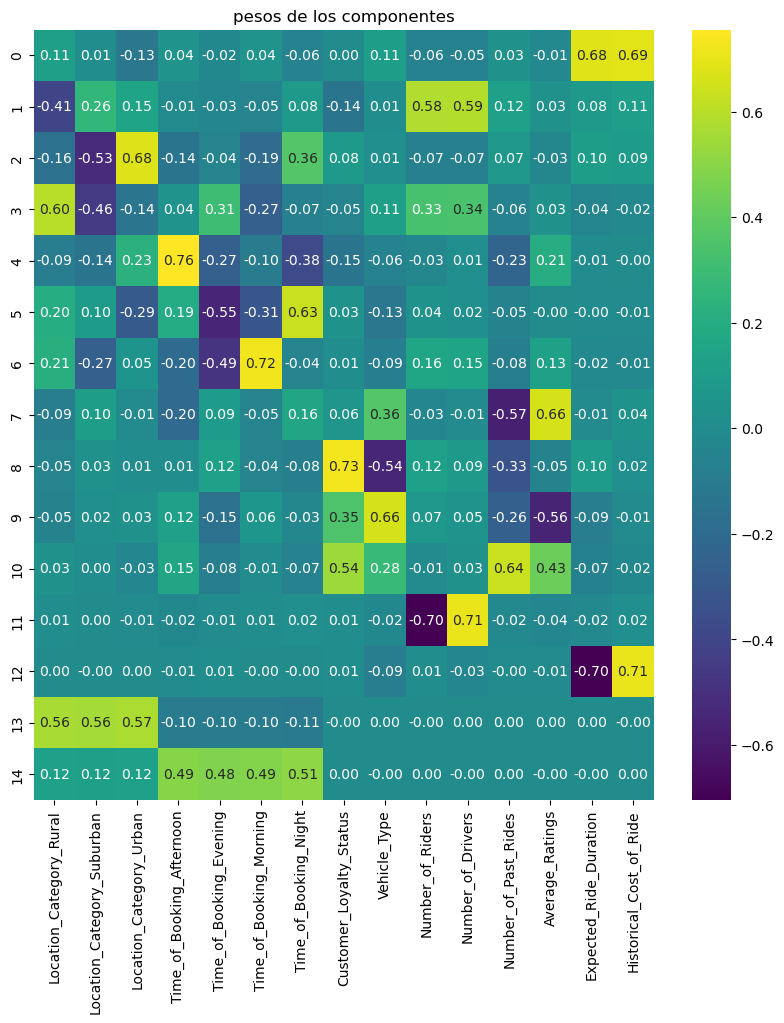

In [11]:
heatmap(componentes, "pesos de los componentes",  tamaño=(10,10), mapa="viridis")

## Varianza Explicada

### matrix porcentaje varianza y porcentaje acumulado

Se construyo un grafico para visualizar el porcentaje de la varianza total explicada por cada componente. Se observan los valores individuales, asi como una curva con el acumulado total. Como una linea base para juzgar los porcentajes, si la varianza se distribuyera aleatoriamente se esperaria que cada componente explique un $100/15=6.66\%$. Se observa que la direccion de mayor varianza es la que indica el componente 0, que explica el $13\%$ de varianza. las componentes 1-6 superan tienen valores entre el al $8.7\%$ - $11.6\%$, superando bastante la base de $6\%$. El resto de los componentes se acerca a la base, y los componentes 13-14 no explican la varianza. 

Observando la linea de acumulación, se observa un lineal de la varianza explicada hasta llegar a la componente 10, donde se ve un aplanamiento de la curva. Esto sugiere que los componentes 0-10 son los mas significativos, y se deberian tomar para hacer una reducción de dimensionalidad, reduciendose de las 15 variables a 10 pseudovariables.

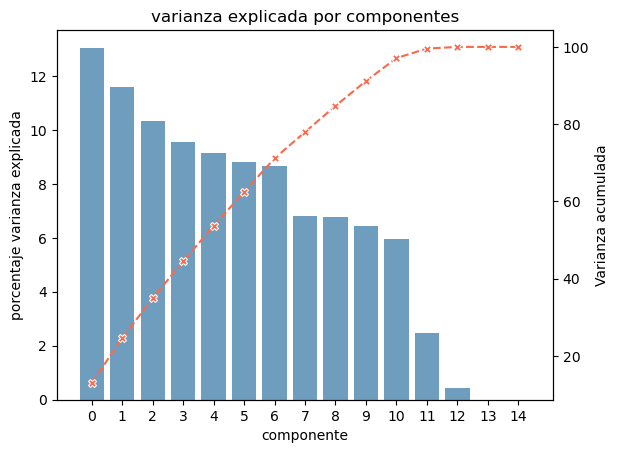

In [12]:
varianza_acumulada = pd.DataFrame(modelo_pca.explained_variance_ratio_).transform("cumsum") * 100
ax = sns.barplot(modelo_pca.explained_variance_ratio_*100, alpha=0.7)

ax.set_title("varianza explicada por componentes")
ax.set_xlabel("componente")
ax.set_ylabel("porcentaje varianza explicada")

ax2 = ax.twinx()
ax2.set_ylabel("Varianza acumulada")

sns.lineplot(varianza_acumulada, legend=False, palette="Reds",  marker="X", ax = ax2)

ax2.lines[0].set_linestyle("--")

plt.show()

### Screeplot varianza explicada 

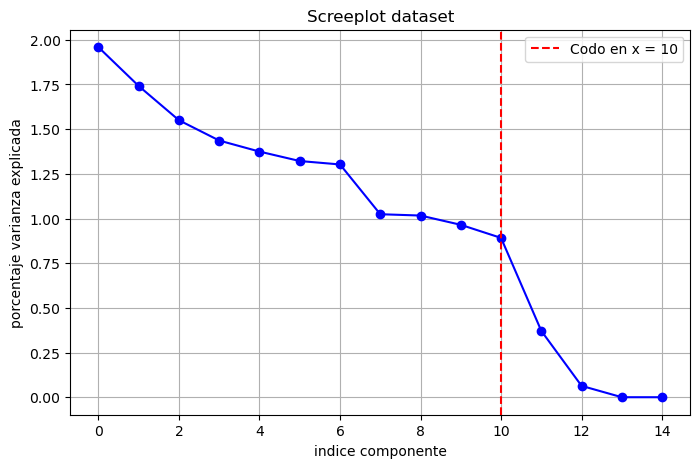

In [18]:
indices_comp = np.arange(15)

codo = punto_codo(indices_comp, modelo_pca.explained_variance_)

grafico_codo(indices_comp, modelo_pca.explained_variance_, ("Screeplot dataset", "indice componente", "porcentaje varianza explicada"),  punto_codo=codo)

### Analisis:

El screeplot muestra que la varianza explicada de los componenentes 0-6 es basante alta, ya que explican >= 1.25 veces la varianza.

El punto de codo calculado nos dice cual es el número de componentes que deberian tomarse para reduncir dimensionalidad. En este caso muestra que deberian tomarse 10 componentes. Este resultado coincide con la disminución significativa de la varianza total que se observa en el grafico anterior. Ambos metodos terminan estando de acuerdo sobre el numero de componentes.


In [35]:
for i in zip(combinations("ABCD", 2)):
    print(i)

(('A', 'B'),)
(('A', 'C'),)
(('A', 'D'),)
(('B', 'C'),)
(('B', 'D'),)
(('C', 'D'),)


# KNN (Agrupamiento K-Medias)

El metodo de los k vecinos mas cercanos utiliza un metodo de medicio democratico para encontrar las similaridades entre los puntos muestrales: se calcula un punto que es el resumen de todos los puntos en los datos, llamado centroide, y va agregando los puntos que se acerquen mas al centroide. Con este nuevo cluster se calcula nuevamente el centroide, y se repite el proceso. los centroides se generan aleatoriamente al inicio del entrenamiento, y la distancia se calcula con una formula, que en la mayoria de los casos es una distancia euclidiana simple. El modelo de KNN se entrenó en este caso con el clasificador `KMeans`, que implementa el metodo de los k vecinos mas cercanos. 

In [117]:
# K-Means con 4 clusters
modelo_kmeans = KMeans(n_clusters=4, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=600)

modelo_kmeans.fit(X_clustering)

KMeans(init='random', n_clusters=3, n_init=10, random_state=60)

In [33]:
# Obtener los centros de los clústeres y las etiquetas de clúster para cada punto de datos
centroids = modelo_kmeans.cluster_centers_
labels = modelo_kmeans.labels_

print(centroids)
print(labels)

[[8.72588010e-01 2.95539482e-01 4.79882030e-02 2.62492948e-01
  3.42215989e-01 1.43369176e-04 5.37634409e-03 2.06989247e-01
  4.25627240e-01 5.52999951e-01 5.57526882e+00 2.40161290e+01
  3.76344086e-01 2.70430108e+00 3.00000000e+00]
 [8.92742641e-01 3.05236691e-01 4.12032345e-02 2.50206856e-01
  2.87264878e-01 5.39007092e-04 1.74940898e-02 1.65957447e-01
  4.22931442e-01 5.44382888e-01 5.49361702e+00 1.30893617e+01
  6.46808511e-01 2.71914894e+00 1.45106383e+00]
 [9.14611872e-01 2.89453889e-01 6.21110230e-02 2.43998628e-01
  3.39184112e-01 1.02222222e-02 1.74485597e-02 4.62962963e-02
  4.12992357e-01 5.87011832e-01 5.50740741e+00 3.86666667e+00
  1.02592593e+00 2.27777778e+00 2.18518519e-01]]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [118]:
df_centroides = pd.DataFrame(modelo_kmeans.cluster_centers_)

df_centroides.columns = caracteristicas

### Ajuste del modelo:

In [35]:
y_entre_pred = modmul.predict(X_entre_lin[caracteristicas])
y_prueba_pred = modmul.predict(X_prueba_lin[caracteristicas])

### Visualización:

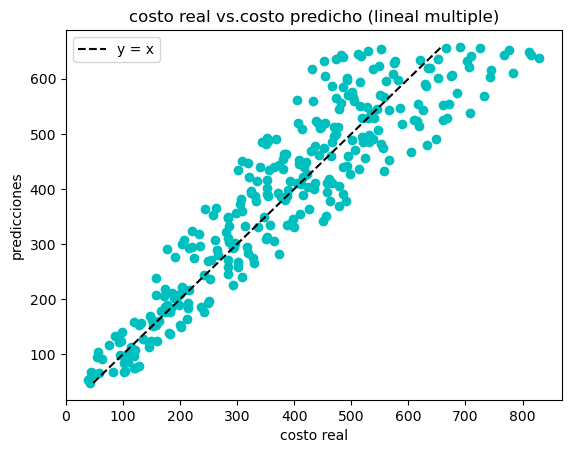

In [36]:
grafico_real_vs_predicho(y_prueba_lin, y_prueba_pred,
                         'costo real vs.costo predicho (lineal multiple)',
                         'costo real',
                         'predicciones')

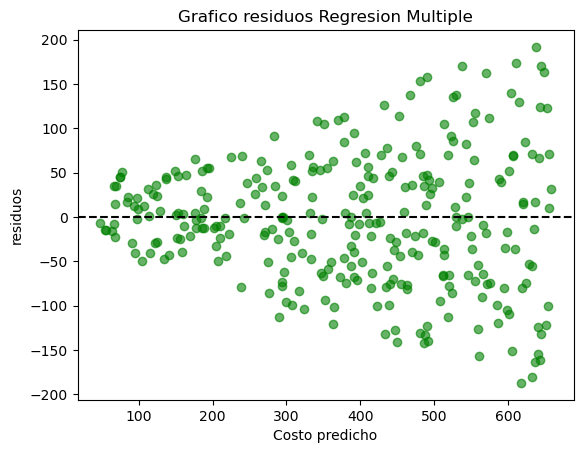

In [37]:
grafico_residuos(y_prueba_lin, y_prueba_pred, 
                 "Grafico residuos Regresion Multiple", 
                 "Costo predicho", 
                 "residuos")

### Analisis:

El gráfico de predicciones vs. valores reales sigue la tendencia de la recta $y = x$. Muestra que el modelo lineal multiple es capaz de predecir los valores del costo. La dispersión de los puntos es similar al modelo linea de *Costo vs. duración esperada*. Como tambien se esta incluyendo la variable de *duración esperada del viaje* en el modelo, tiene sentido que las graficas de regresión se parezcan.

El gráfico de residuos muestra que hay una tendencia de los errores, similar a la que se presento en el modelo *Coso vs. duración esperada*. Esto muestra que la tendencia de los errores se deebe unicamente a la inclusión de la variable de *duración esperada del viaje*. Tampoco se cumple el criterio de homocestadicidad, lo que limita el analisis de las pruebas estadisitcas aplicadas. 

### Metricas y Parametros:

In [39]:
print("metricas entrenamiento:")
print(mostrar_metricas(y_entre_lin, y_entre_pred, num_predictores=4))

print("metricas prueba:")
print(mostrar_metricas(y_prueba_lin, y_prueba_pred, num_predictores=4))

metricas entrenamiento:
R2    : 0.8697
R2_adj: 0.8689
MSE   : 4659.3354
RMSE  : 68.2593
MAE   : 53.8421
metricas prueba:
R2    : 0.8416
R2_adj: 0.8395
MSE   : 5244.8792
RMSE  : 72.4215
MAE   : 57.3789


In [19]:
# pendientes e intercepto, concatenados para el calculo del test t
parametros = np.append(modmul.coef_, modmul.intercept_)

valores_t, valores_p = calcular_valor_t(X_prueba_lin[caracteristicas], y_prueba_lin, y_prueba_pred, parametros, 0)

mostrar_parametros(caracteristicas, modmul, valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Number_of_Riders,0.006,0.065,0.949
1,Number_of_Drivers,0.404,4.033,0.000
2,Number_of_Past_Rides,0.003,0.032,0.975
3,Expected_Ride_Duration,3.559,35.575,0.000
4,intercepto,7.862,78.587,0.000


### Analisis:

La coeficientes hallados son las pendientes, que se pueden interpretar cada una como:

- EL costo aumenta 0.006 unidades cuando el número de pasajeros disponibles en el área aumenta.
- El costo aumenta 0.404 unidades por cada conductor que haya disponible en el área.
- El costo aumenta 0.003 unidades por cada viaje que el vehiculo hay completado.
- El costo aumenta 3.559 unidades por cada minuto adicional que aumente la duración esperada.
- El intercepto muestra un costo base de 7.862.

La pendiente hallada para la duración esperada es muy cercana a la hallada en el modelo lineal simple.

En los datos de preuba, Las metricas de $R^2$ y $R^2_{adj}$ tienen el valor de $84.16\%$ y de $83.95\%$, estando muy cercanos entre ellos. El RMSE de ($72.42$) es un valor mucho menor comparado con la magnitud del costo, mostrando una baja desviación entre predicciones y valores reales. Este modelo predice bien el costo, y es ligeramente mejor que el lineal simple de *Costo vs. Duración esperada*.

La prueba estadistica revela que *El número de condutores disponibles* y *la duración esperada del viaje* son las unicas variables significativas del modelo, ya que estan bajo el umbral de $0.05$. Sin embargo, debido a los resultados vistos en la grafica de residuos, se pierde generalidad en la prueba estadistica, y tambien es necesario tomar acciones para reestablecer la homocesdasticidad.


# Agrupamiento Jerarquico

### Ajuste del modelo:

In [115]:
df_clustering = df_entre.drop(["año", "department", "dia", "mes", "nombre_dia", "quarter"], axis=1)
X_clustering = df_clustering.values
caracteristicas = df_clustering.columns

In [131]:
modelo_agg = AgglomerativeClustering(n_clusters=3)

labels = modelo_agg.fit_predict(X_clustering)

In [133]:
# Obtener los centros de los clústeres y las etiquetas de clúster para cada punto de datos
labels = modelo_agg.labels_

print(labels)

[2 1 1 2 2 0 0 0 1 1 0 0 0 0 2 1 1 0 2 2 1 0 0 1 2 1 2 2 0 0 0 1 1 0 1 0 1
 2 2 0 1 2 1 0 0 1 0 0 0 1 0 0 0 1 2 2 2 1 1 0 0 1 2 0 0 2 0 1 2 1 0 1 1 0
 0 2 2 0 0 1 2 1 1 0 1 2 2 0 0 1 2 0 1 0 1 0 1 0 2 2 2 1 0 1 0 1 0 0 0 1 2
 2 0 2 1 0 1 0 1 0 0 1 2 2 2 1 0 0 1 0 0 1 2 1 2 1 2 0 0 0 1 1 0 0 2 2 1 2
 1 0 0 0 1 1 0 2 1 2 2 0 1 0 0 1 0 1 0 2 2 2 1 0 1 1 0 1 0 0 0 2 2 1 0 0 0
 1 1 0 2 0 1 2 2 1 0 1 0 0 1 0 1 2 0 2 2 0 1 0 0 1 0 1 1 2 0 0 2 1 0 0 0 1
 1 2 2 1 0 0 0 1 2 0 1 1 0 2 1 2 0 0 0 0 2 1 2 1 0 1 1 2 0 2 0 0 0 1 0 1 1
 2 1 0 0 1 0 0 1 1 2 2 0 1 0 0 1 0 0 0 1 1 1 2 2 2 0 0 0 1 0 1 0 1 1 2 2 0
 0 1 0 1 0 1 0 1 2 2 2 0 0 0 1 0 1 1 1 2 2 2 0 0 0 1 1 0 1 1 2 0 2 2 0 1 0
 0 0 1 1 1 2 2 2 0 0 0 1 0 1 1 2 2 1 2 0 0 0 0 1 0 1 1 1 2 0 2 0 2 0 0 0 1
 1 1 2 1 2 0 0 2 0 1 0 0 1 1 2 1 0 0 2 2 1 0 0 1 0 1 0 1 0 2 2 2 1 0 0 0 1
 1 2 1 0 0 2 2 0 0 1 2 1 1 0 2 0 2 0 1 0 0 1 0 2 0 2 1 1 2 1 0 0 1 0 0 0 2
 2 1 2 0 0 1 0 2 2 2 1 0 0 0 1 0 0 0 1 2 0 2 2 1 1 1 0 1 2 0 2 1 0 0 1 2 0
 1 1 0 0 1 0 2 2 0 1 0 1 

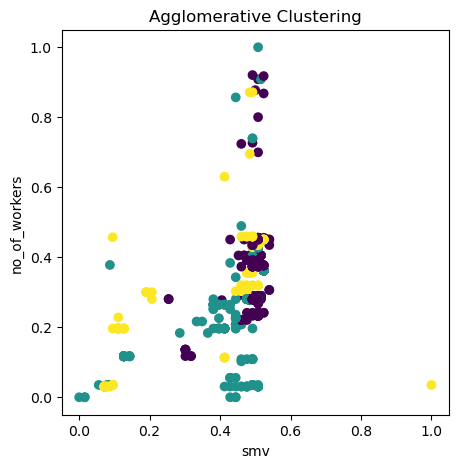

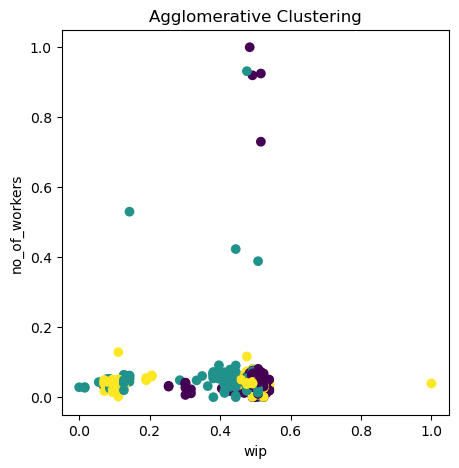

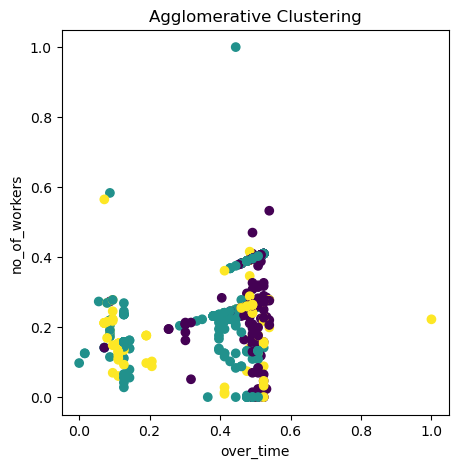

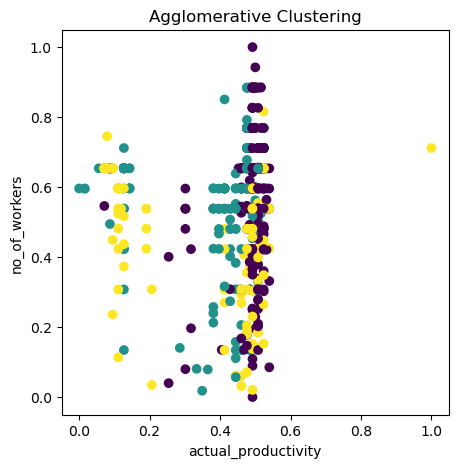

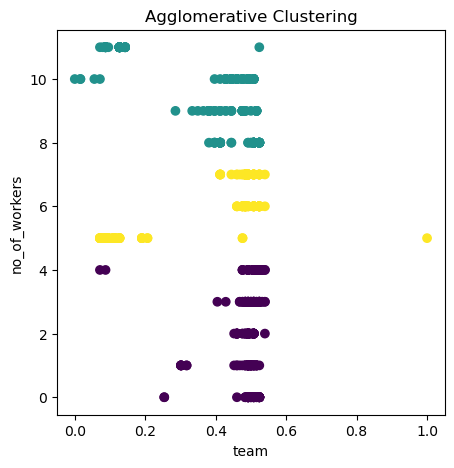

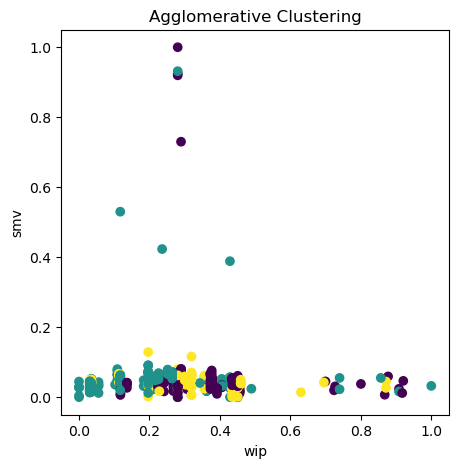

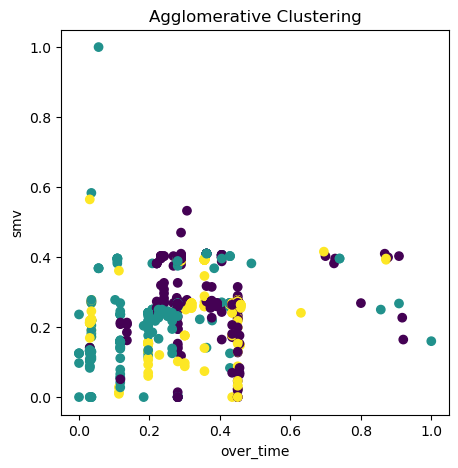

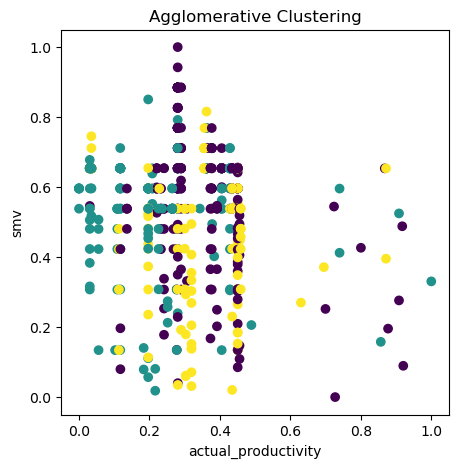

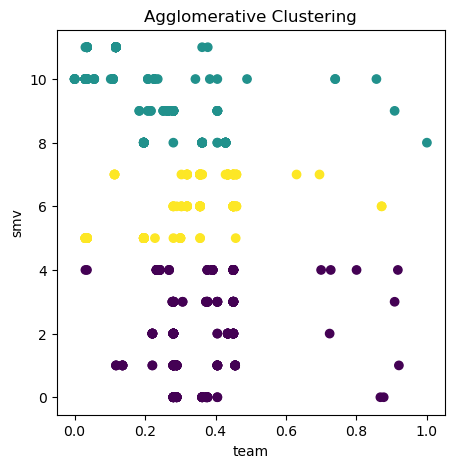

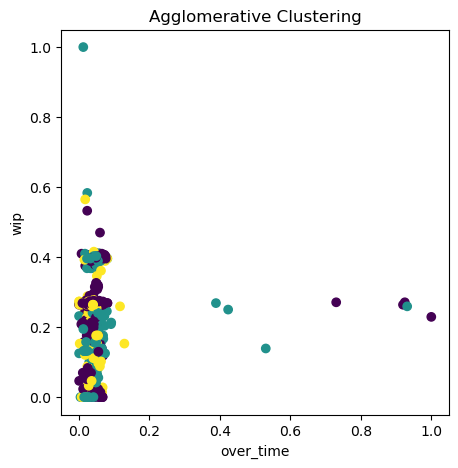

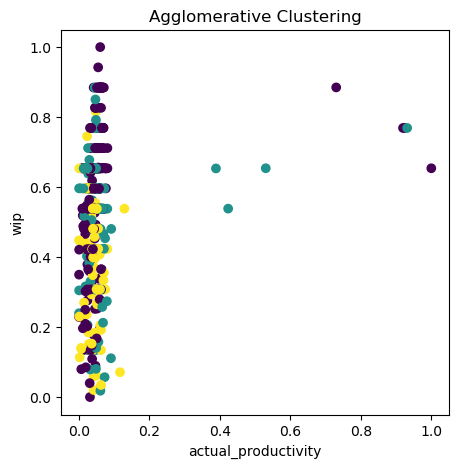

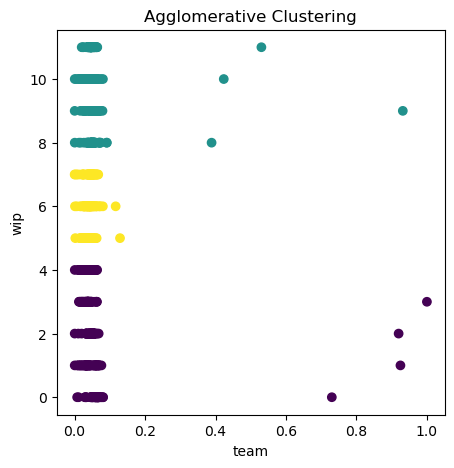

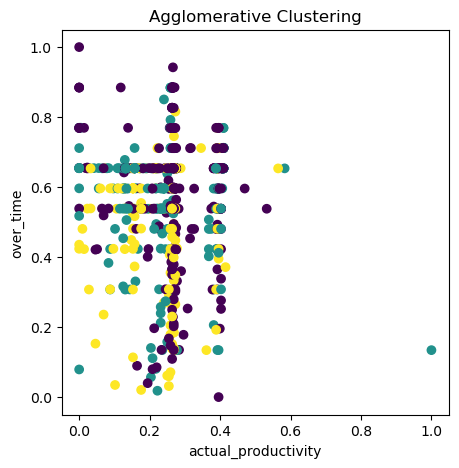

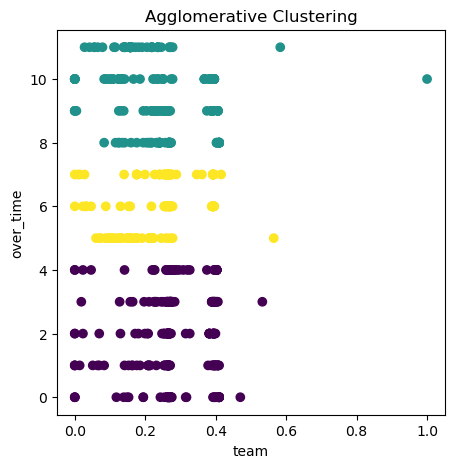

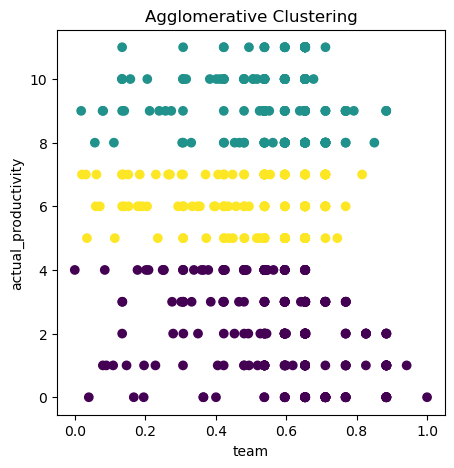

In [134]:
# Graficar los datos coloreados por sus etiquetas de clúster
conjunto_cluster_plot(X_clustering, caracteristicas, modelo_agg)

In [135]:
print(f"Tamaños de los cluster con el método agglomerative clustering: {np.bincount(labels)}")

Tamaños de los cluster con el método agglomerative clustering: [288 233 170]


Text(0, 0.5, 'Distancia entre clusters')

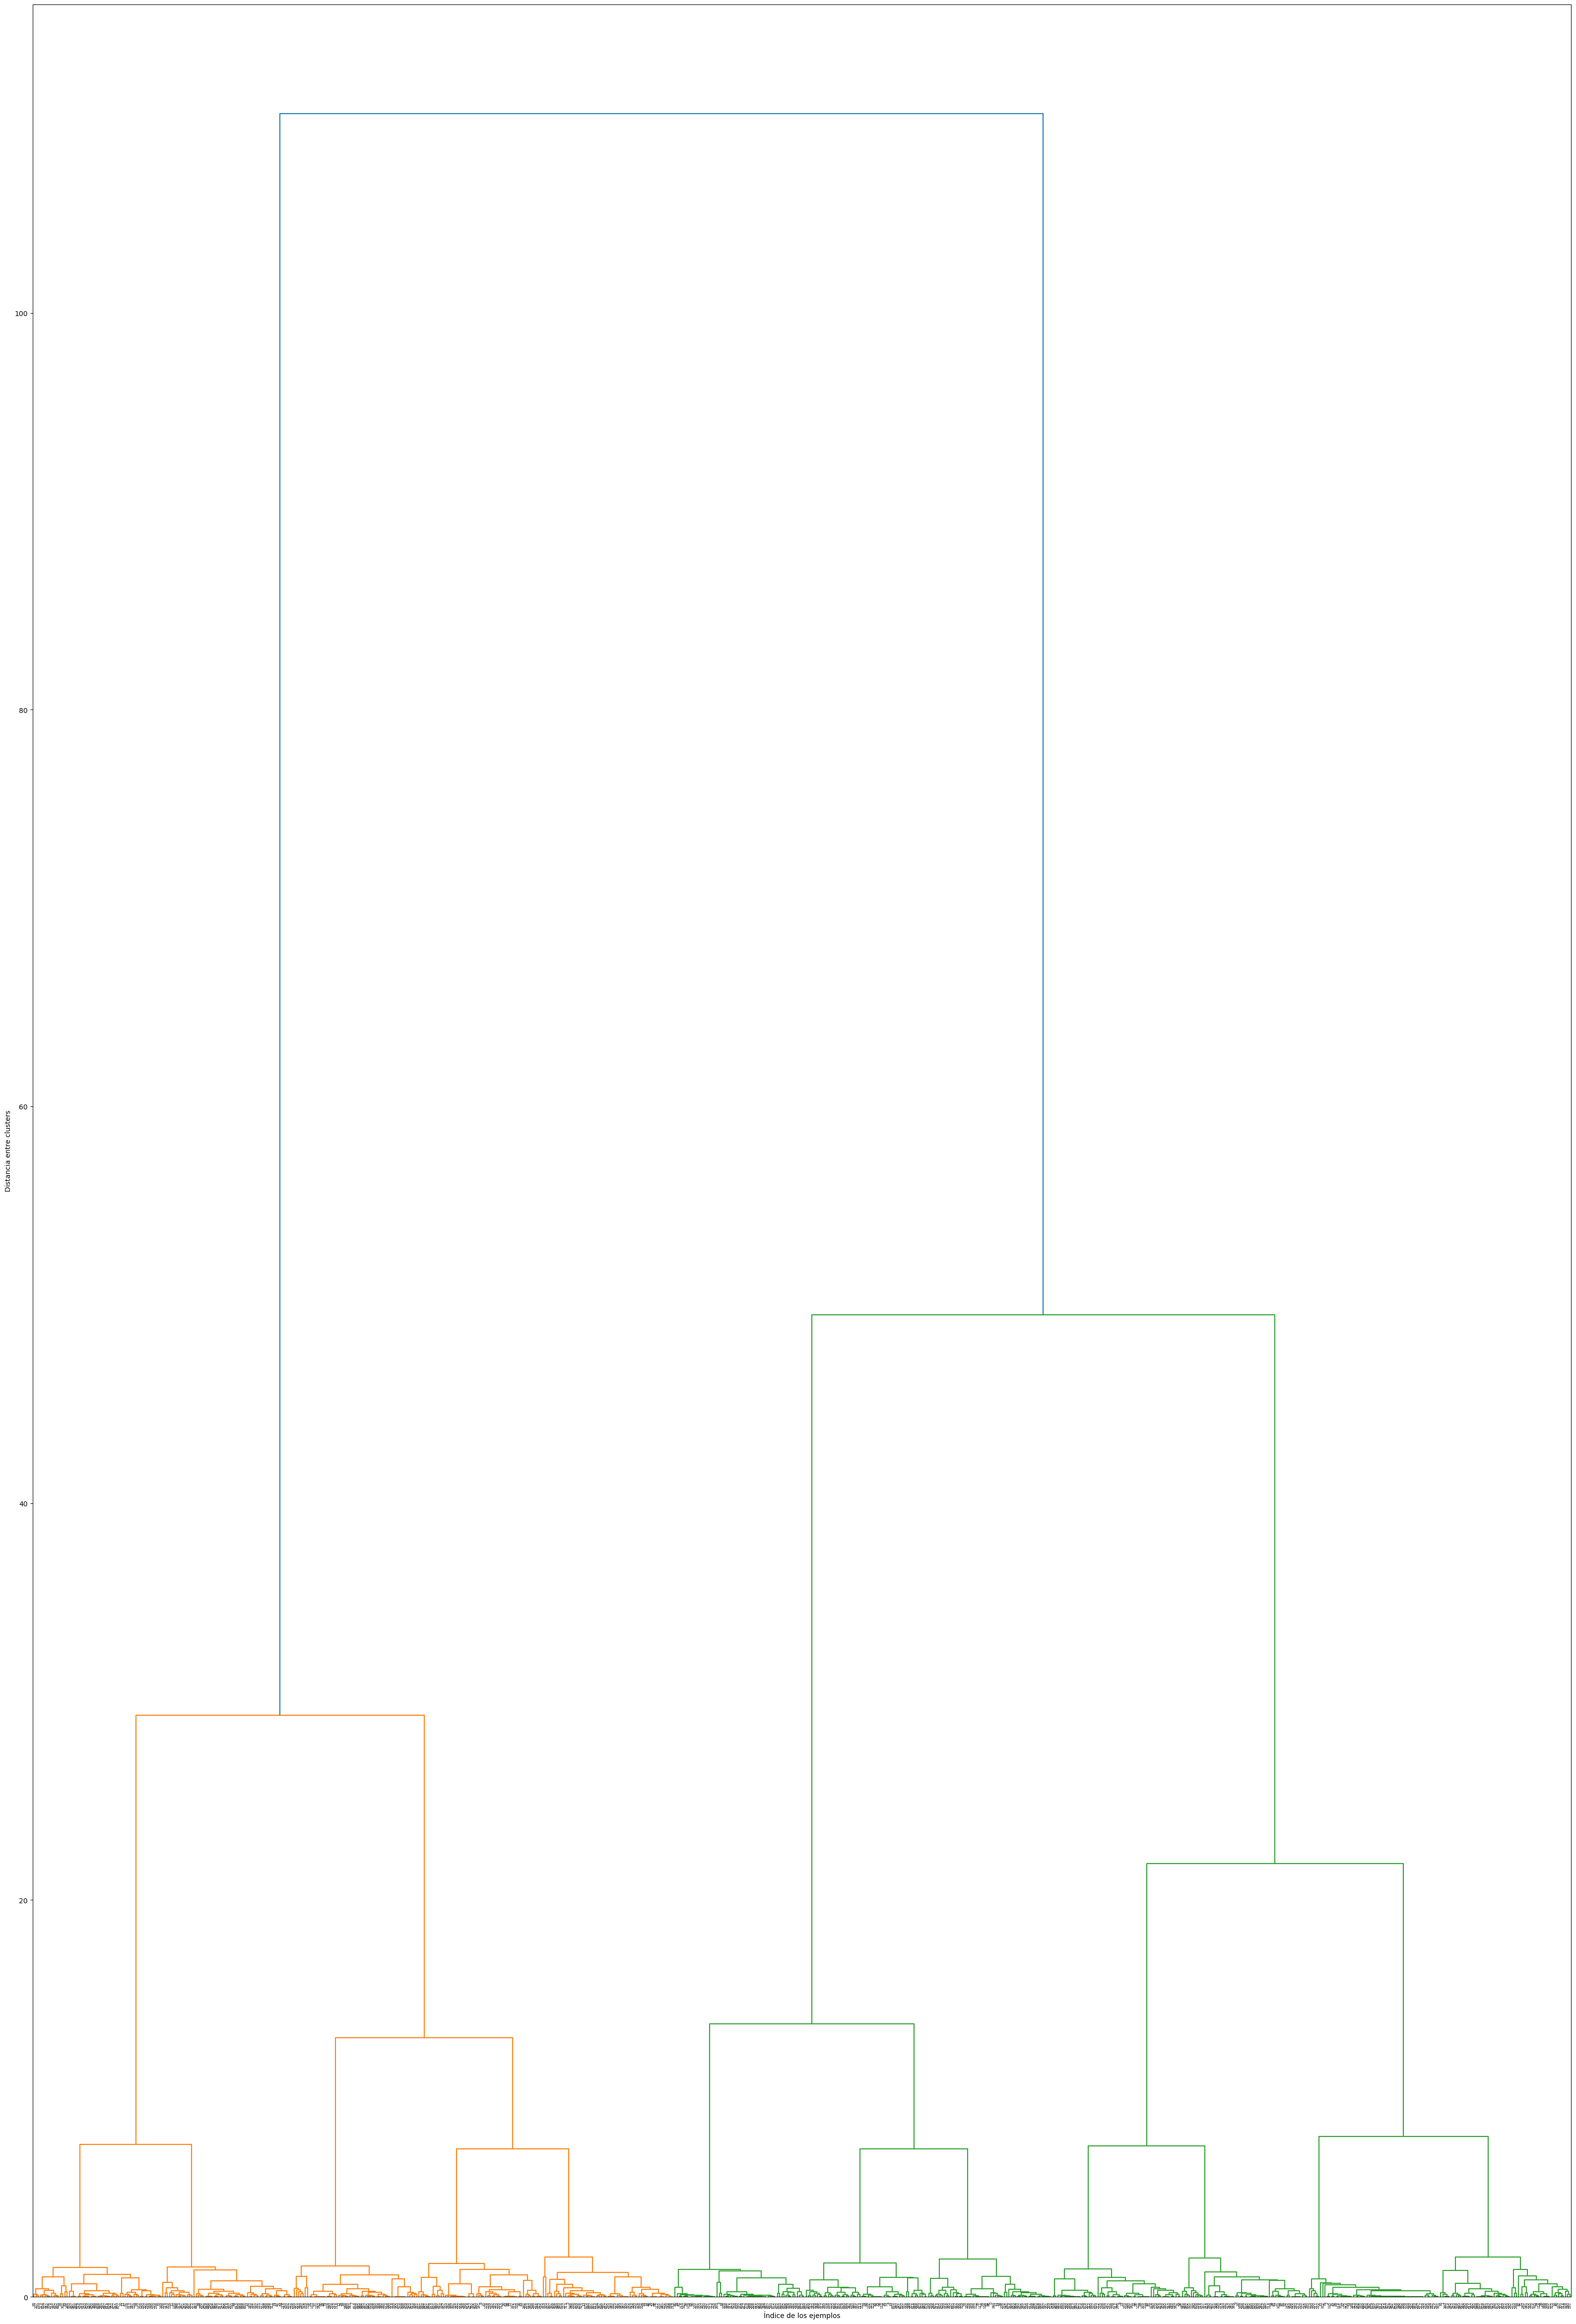

In [130]:
from scipy.cluster.hierarchy import dendrogram, ward

# Aplicamos ward clustering a los datos X2
# La función ward de SciPy devuelve una matriz con las distancias al realizar el agrupamiento
linkage_array = ward(X_clustering)


# Dendrograma para linkage_array que contiene las distancias entre clusters
plt.figure(figsize=(40, 60))
dendrogram(linkage_array)
plt.xlabel("Índice de los ejemplos")
plt.ylabel("Distancia entre clusters")

In [49]:
# caracteristicas que se mencionaron en el apartado anterior
caract_log = [Categ.locacion.value, Categ.tiempo_viaje.value, Categ.lealtad.value, Categ.vehiculo.value]

# se usa la clase ColumnTransformer para juntar varias trasnformaciones juntas, y poder realizarlas en el las variables, como si fuera una sola unidad

prep_categorico = ColumnTransformer([
    ('codificado_nominal', OneHotEncoder(), [Categ.locacion.value, Categ.tiempo_viaje.value]),
    ('codificado_ordinal', OrdinalEncoder(), [Categ.lealtad.value, Categ.vehiculo.value]),
                         ],
    remainder='passthrough')

modlog = Pipeline([
    ("prep_categorico", prep),
    ("standar", StandardScaler())
])


# La clase binarize permite dividir los datos en grupos de  1 y 0, dependiendo de cual sea el limite de la division. En este caso es cuatro
puntaje_limite = 4

calidad = binarize(df_modelos[[Num.puntaje_promedio.value]], threshold=puntaje_limite).ravel()

X_entre_log, X_prueba_log, calidad_entre, calidad_prueba = train_test_split(df_modelos[caract_log],
                                                        calidad, 
                                                        train_size=0.7,
                                                       random_state=600) 

In [50]:
#construyendo las variables para el nivel de produtividad (productividad alta: 1; productividad baja: 0)

modlog = Pipeline([
    ("preprocesamiento", prep),
    ("logistico", LogisticRegression())
])

modlog.fit(X_entre_log, calidad_entre)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('codificado_nominal',
                                                  OneHotEncoder(),
                                                  ['Location_Category',
                                                   'Time_of_Booking']),
                                                 ('codificado_ordinal',
                                                  OrdinalEncoder(),
                                                  ['Customer_Loyalty_Status',
                                                   'Vehicle_Type'])])),
                ('logistico', LogisticRegression())])

In [51]:
calidad_entre_pred = modlog.predict(X_entre_log)
calidad_prueba_pred = modlog.predict(X_prueba_log)

El uso de los encoders para las variables categoricas ofusca cuales variables se estan usando realmente para el modelo. El siguiente fragmento es para extraer las caracteristicas usadas por el modelo, y poder presentarlas mas claramente

In [52]:
### fragmento de codigo para visualizar mejor a que variable corresponde cada parametro hallado
desglose_caract = []

encoder = modlog.named_steps["preprocesamiento"].transformers_[0][1]

for categ in encoder.categories_:
    desglose_caract.extend(categ)

desglose_caract.extend(caract_log[-2:])

### Radios Odd

In [53]:
parametros_log = np.append(modlog.named_steps["logistico"].coef_, modlog.named_steps["logistico"].intercept_)

radios_odd = pd.DataFrame({"variable": desglose_caract + ["intercepto"], 
                           "radios odd":np.exp(parametros_log)})

display(radios_odd)

,variable,radios odd
0,Rural,0.918
1,Suburban,1.025
2,Urban,1.053
3,Afternoon,1.168
4,Evening,0.721
5,Morning,1.270
6,Night,0.927
7,Customer_Loyalty_Status,0.959
8,Vehicle_Type,0.937
9,intercepto,2.362


### Analisis 

Los odd radios son la cantidad adimensional $\frac{P}{1-P}$ de la ecuación del modelo logistico. La expresion nos indica una relación sobre las probabilidades de la ocurrencia del evento, sobre la no ocurrencia. En este caso, el evento es que la calidad de viaje sea buena, y la ausencia del evento implica que la calidad del viaje sea mala. El odd radio se puede desglosar para cada uno de los parametros del modelo, y se interpretan de forma similar. Para el modelo presente seria:

- Para la variable locación del viaje:

> - Nivel Rural: indica que, en zona rural, es $0.918$ veces más probable que el servicio sea bueno, frente a que el servicio sea malo. Esto en realidad que implica que es $1/0.918 = 1.09$  veces mas probable que el servicio sea malo en zona rural.
> - Nivel Suburbano: indica que, en zona suburbana, es $1.025$ veces mas probable que el viaje sea bueno, respecto a que el viaje sea malo.
> - Nivel Urbano, En la zona urbana, es $1.053$ veces más probable que el servicio sea bueno, frente a que sea malo.

- Para la variable Hora del viaje:

> - Nivel tarde: En las horas de la tarde, es $1.168$ veces más probable que el servicio sea bueno, respecto a que sea malo.
> - Nivel anochecer: Pasa el mismo caso que en la variable locación. En realidad, al anochecher es $1/0.721 = 1.387$ veces más probable que el viaje sea malo, frente a que sea bueno.
> - Nivel Mañana: Es $1.27$ veces más probable que el viaje sea bueno, respecto a que sea malo, en las horas de la mañana.
> - Nivel Noche: En las horas de la noche, es $1/0.927 = 1.079$ veces mas probable que el servicio sea malo, frente a que el servicio sea bueno.

- Para la variable lealtad del cliente: la probabilidad de que el servicio sea malo es $1/0.959 = 1.043$ veces más probable respecto a que el servicio sea bueno. Como la variable es ordinal (0=clase oro, 1=clase plata, 2=clase regular), por cada nivel que aumente la lealtad, la probabilidad de que sea malo aumenta tambien.

Para la variable tipo de vehiculo: la probabilidad de que el servicio sea malo es $1/0.937 = 1.067$ veces más que la probabilidad sea bueno. Como la variable ses ordinal (0=premium, 1= economy), por cada nivel que aumente la variable, la probabilidad de que sea malo aumenta tambien.

### Metricas y Parametros:

In [54]:
acc_entre = metrics.accuracy_score(calidad_entre, calidad_entre_pred)
acc_prueba = metrics.accuracy_score(calidad_prueba, calidad_prueba_pred)

print(f"exactitud entrenamiento: {acc_entre:0.3f}", )
print(f"exactitud prueba: {acc_prueba:0.3f}")

exactitud entrenamiento: 0.683
exactitud prueba: 0.680


In [152]:
print(metrics.classification_report(calidad_prueba, calidad_prueba_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        96
         1.0       0.68      1.00      0.81       204

    accuracy                           0.68       300
   macro avg       0.34      0.50      0.40       300
weighted avg       0.46      0.68      0.55       300



C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualización:

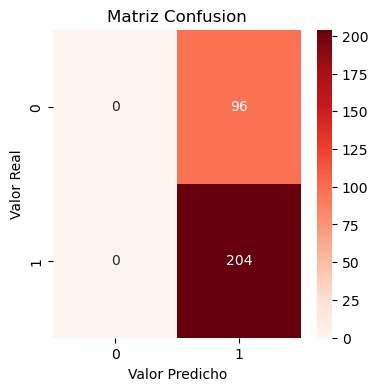

In [201]:
matriz_confusion(calidad_prueba, calidad_prueba_pred)

In [55]:
# pesos y sesgo, concatenados para el calculo del test t
caract_trans = pd.DataFrame(modlog.named_steps["preprocesamiento"].transform(X_prueba_log), columns=desglose_caract  )

valores_t, valores_p = calcular_valor_t(caract_trans, calidad_prueba, calidad_prueba_pred, parametros_log, 0)

mostrar_parametros(columnas, modlog.named_steps["logistico"], valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Rural,-0.085,-1.468,0.143
1,Suburban,0.024,0.421,0.674
2,Urban,0.052,0.896,0.371
3,Afternoon,0.155,2.664,0.008
4,Evening,-0.327,-5.623,0.000
5,Morning,0.239,4.116,0.000
6,Night,-0.076,-1.309,0.192
7,Customer_Loyalty_Status,-0.042,-0.728,0.467
8,Vehicle_Type,-0.065,-1.123,0.262
9,intercepto,0.860,14.784,0.000


### Analisis:

Las metricas de exactitud del modelo logistico muestran que fue capaz de predecir el $68\%$ de los datos de prueba, teniendo un precision alta. Sin embargo, observando las metricas de clasificación y la matrix de confusión del modelo, se puede observar que esa precision solo aplica a los valores de calidad buenos. El modelo es incapaz de predecir si se va a dar un servicio de calidad baja. Esto tambien ser refleja por los valores de recall y el  f1-score de cero para la variable baja: estas metricas no se calculan por que no hay predicciones para una calidad baja.

Las pruebas estadisticas sobre los parametros indican que las unicas variables que tienen significancia son las siguientes: 

- La variable de la hora dle viaje, en los niveles de la tarde, el anochecer y la mañana 

- la constante independiente que se agrega al modelo logistico.

Estos resultados, sin embargo, se ven limitados por la nula capacidad del modelo de poder predecir los casos de calidad baja.

## Conclusiones

### Regresion Lineal Simple

- El modelo de *Costo vs. viajes pasados* fue el que peor se desempeño entre todos los modelos, con un ajuste de $-0.68\%$. El modelo de *Costo vs. duración esperada* fue mejor que el anterior, teniendo un ajuste del $84\%$.

- Los resultados de la prueba estadistica del t-student permiten concluir que la variable de viajes pasados no tiene significancia en la predicción del costo. La prueba estadistica mostraria que la duración esperada si tiene significancia, pero esta conclusión se ve limitada por la falta de la homocedasticidad en el grafico de residuos. Se debe realizar una trasnformación de los datos para poder establecer que la varianza de los errores sea constante. Una de tales trasnformaciones para las regresiones lineales es la función logaritmica. Tambien es posible realizar una regresión lineal con pesos ponderados para evitar la varianza no constante.

### Regresion Lineal Multiple

- El modelo de regresión lineal multiple es el mejor de los construidos, teniendo un ajuste de $84.16\%$. El grafico valores predichos vs. valores reales mostraron igualmente que se dio un buen ajuste, y las demas metricas mostraron buenos resultados.

- El resultado de la prueba estadistica mostraria que las variables con significancia serian el número de conductores en el área, y la duración esperada del viaje. Sin embargo, pasa lo mismo que en el modelo anterior, donde la homocedasticidad no se observa en el grafico de residuos. En el caso del modelo linear multiple, tambien se pueden aplicar transformaciones a las variables para tener varianza constante, o el uso de una regresión lineal ponderada.

### Regresion Logistica

- El modelo logistico tuvo un ajuste menor al modelo lineal multiple, y superior al primer modelo lineal. tuvo una precisión del $68\%$, pero solo es capaz de predecir valores altos de la calidad. Esto se debe a que los datos en estan sesgados hacia valores altos de la calidad, por lo que se debe hacer un balanceo de los datos para mejorar el modelo

- Se encontró que solo los niveles de la variable de la hora de viaje son significativos en la predicción de la calidad. Sin embargo, estos resultados se ven limitados por la prescencia del desbalanceo de los datos.

## Enlaces Sustentación:

## [Diapositivas](https://view.genially.com/67206a039d6a5ac3863f8b56/presentation-informe-aprendizaje-estadistico)

## [Presentación](https://youtu.be/KnqF6oqtnYY)

# Referencias

- Kane, F. (2017). Hands-On Data Science and Python Machine Learning. Packt
Publishing.

- Rubio, M. (2019). Estadística con aplicaciones en R. Utadeo.

- Samuels, M., Witmer, J., & Shaffner, A. (2012). Fundamentos de Estadística Para Las Ciencias de la Vida (4th ed.). Pearson.

